# Linear regression

Model trying to predict value of a variable($y_i$) using a linear relationship with another variable($x$) or variables<br>
$$\hat y_i = b_0 + b_1x$$
where $\hat y_i$ is the predicted value<br>

residual: absolute of (predicted value minus the actual value) $|\hat y_i - y_i|$<br><br>
We're trying to minimise sum of the residuals $\min(\sum_i|\hat y_i - y_i|)$<br>
We could also attribute a squared residual penalty for a model and try to minimise that $\min(\sum_i(\hat y_i - y_i)^2)$<br>

simple linear regression: $y_i = b_0 + b_1x$<br>
multiple linear regression: $y_i = b_0 + b_1x_0 + b_2x_1 + ... b_nx_{n-1}$<br>

Assumptions for modelling with linear regression:
 - linearity: (y should be linearly distributed w.r.t x)
 - independence: there is no relationship between y and residuals
 - normality: the residuals plot w.r.t. x must be normally distributed
 - homoscedasticity: the residual plot w.r.t. x must have equal variances across different sections

### Evaluating linear regression

#### Mean absolute error
$\dfrac{\sum_i^n|\hat y_i - y_i|}{n}$<br>

#### Mean squared error
$\dfrac{\sum_i^n(\hat y_i - y_i)^2}{n}$<br>

#### Root Mean squared error
$\sqrt{\dfrac{\sum_i^n(\hat y_i - y_i)^2}{n}}$<br>

#### $R^2$ - Coff. of determination
$R^2 = 1 - \dfrac{RSS}{TSS}$<br>
where RSS is the sum of squared residuals<br>
$RSS = \sum_{i = 1}^{n}(y_i - \hat y_i)^2$
and TSS is the total sum of squares<br>
$TSS = \sum_{i = 1}^{n}(y_i - \bar y_i)^2$, where $\bar y_i$ is the mean of $y_i$s<br>
*Note: $=>$ model whose $R^2$ is closer to 1 is a better model than a model whose $R^2$ is closer to zero*

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

# Dataset:

https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand

In [3]:
cols = ["date", "bike_count", "hour", "temp", "humidity", "wind_speed", "visibility", "dew_point", "solar_radiation", "rainfall", "snowfall", "season", "holiday", "functional_day"]
df = pd.read_csv("seoul_bike_demand/SeoulBikeData.csv")
df.columns = cols
df["season"] = df["season"].astype('category').cat.codes
df["holiday"] = (df["holiday"] == "No Holiday").astype(int)
df["functional_day"] = (df["functional_day"] == "Yes").astype(int)
df = df.drop("date", axis = 1)

In [4]:
df8 = df[df["hour"] == 8]
df8 = df8.drop("hour", axis = 1)

df12 = df[df["hour"] == 12]
df12 = df12.drop("hour", axis = 1)

df16 = df[df["hour"] == 16]
df16 = df16.drop("hour", axis = 1)

df20 = df[df["hour"] == 20]
df20 = df20.drop("hour", axis = 1)
df20.head()

df_hour = {8: df8, 12: df12, 16: df16, 20: df20}


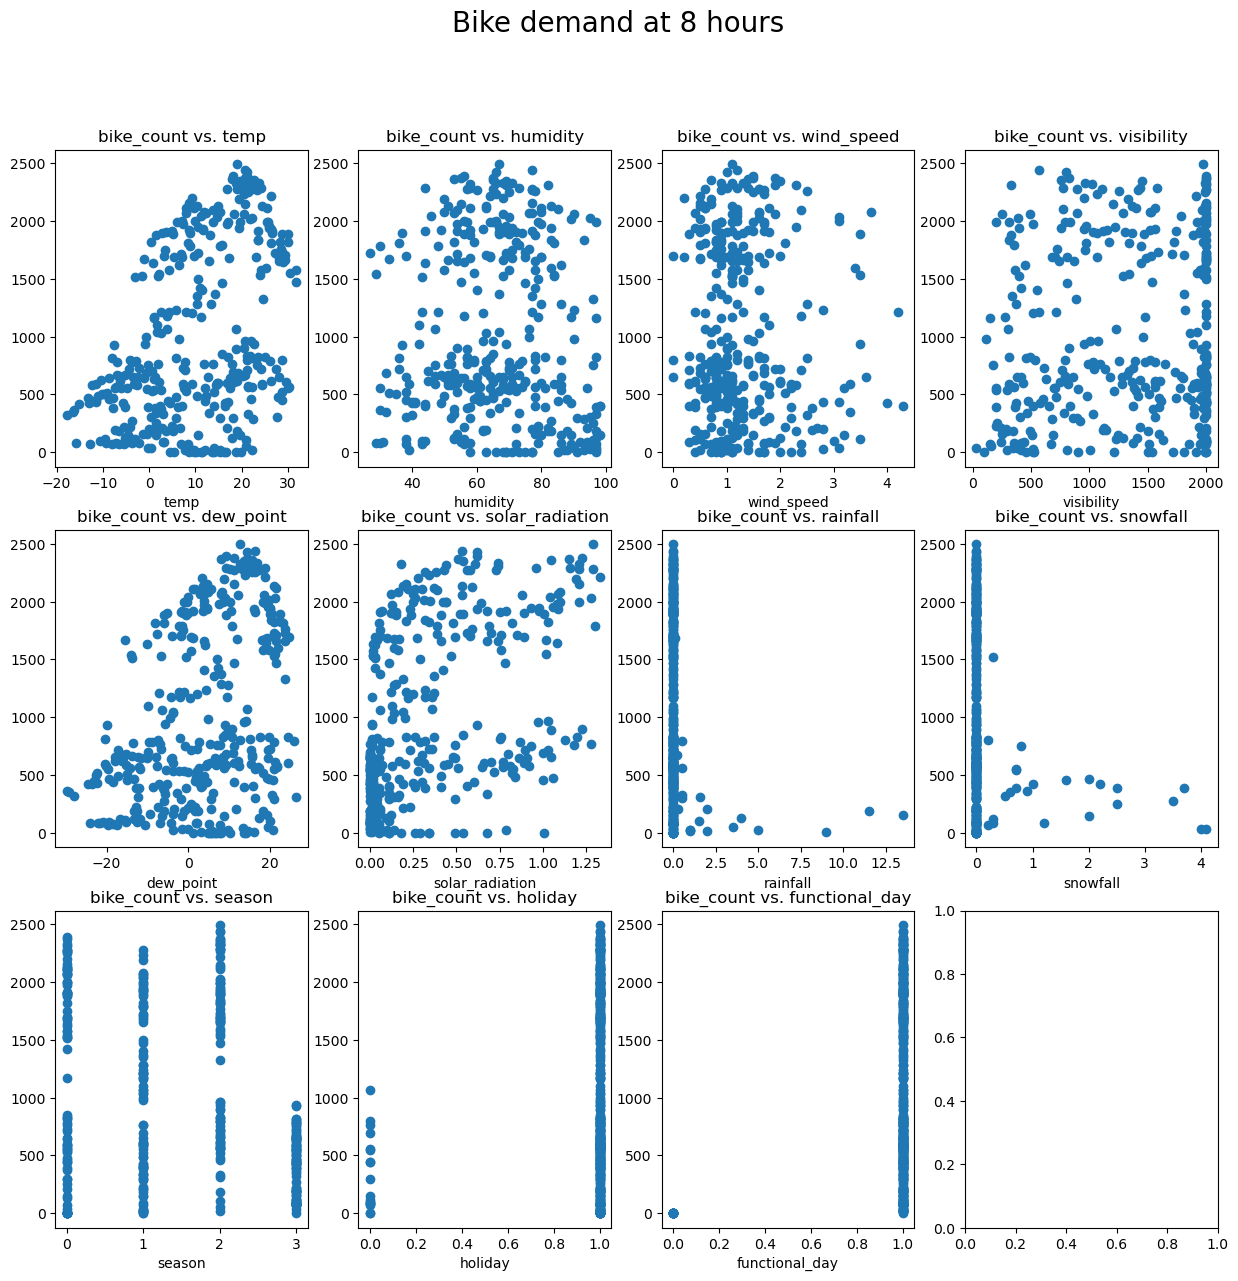

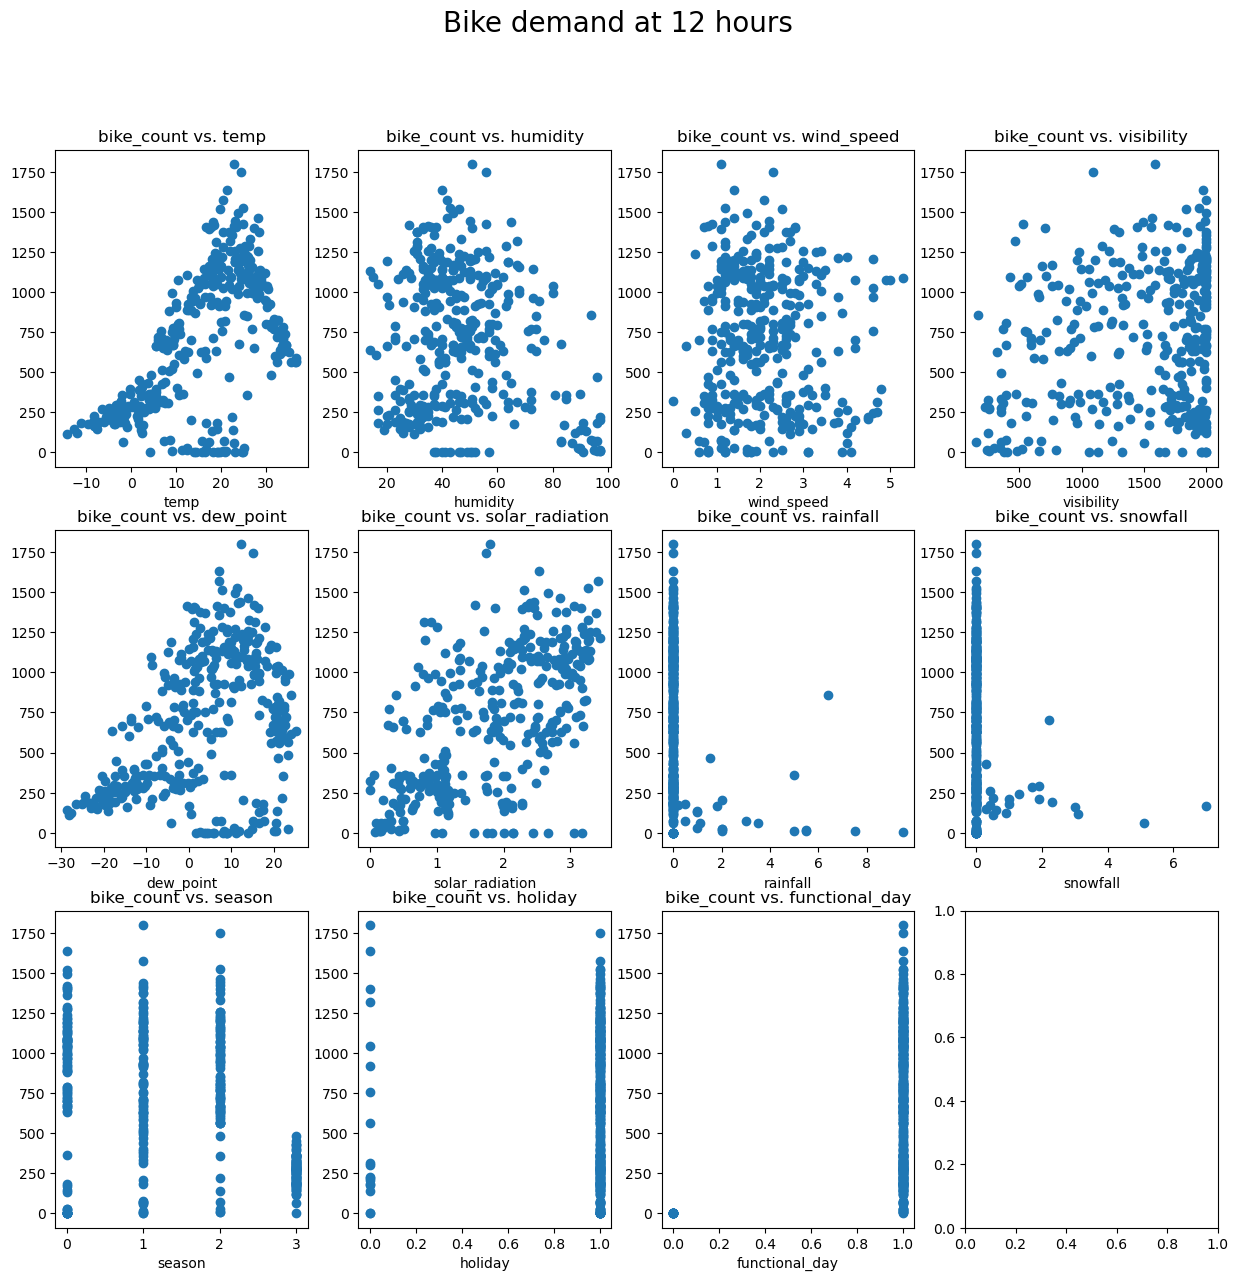

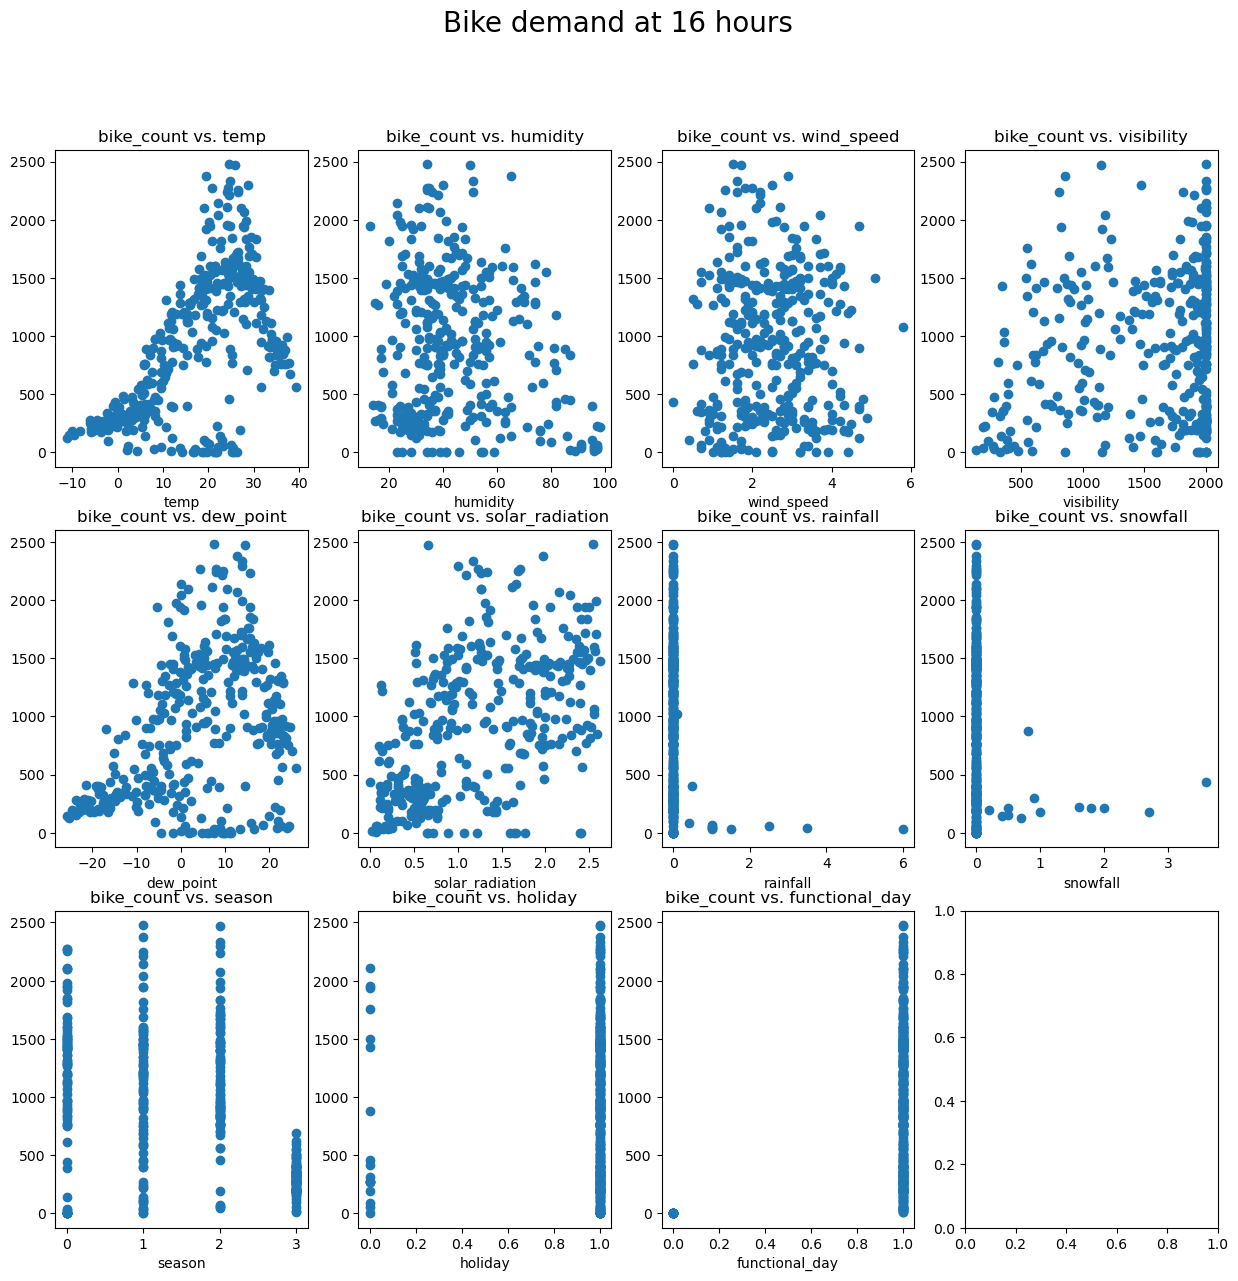

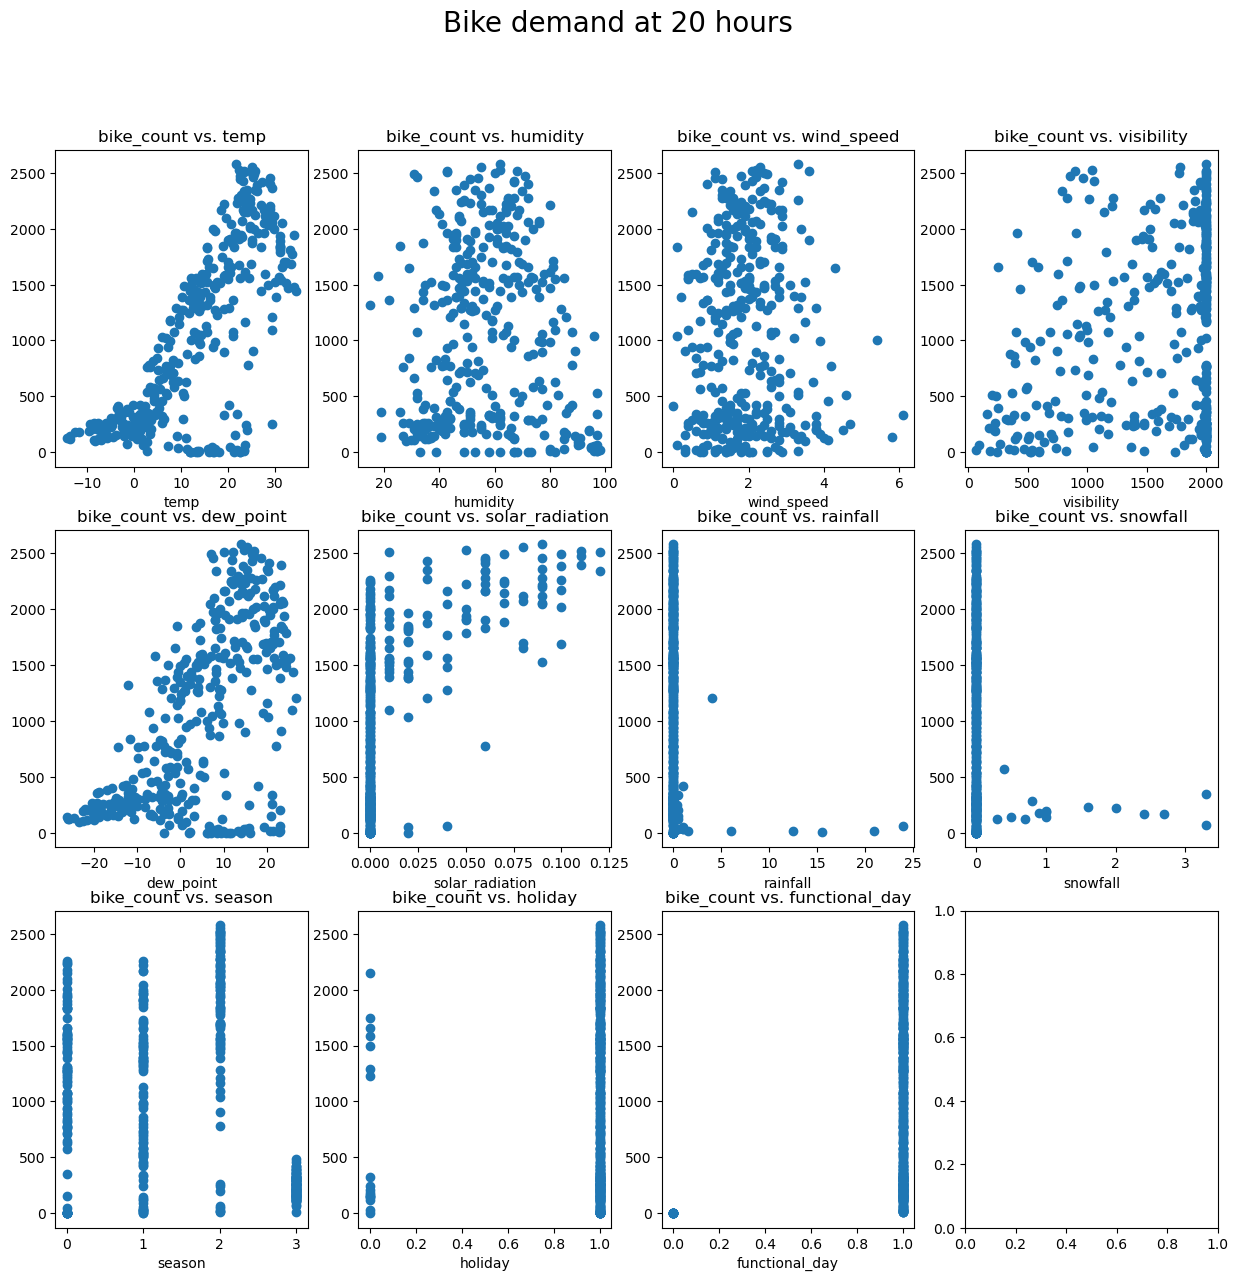

In [5]:
for hour, dfi in df_hour.items():
    fig, axs = plt.subplots(nrows = 3, ncols = 4, figsize = (15, 14))
    for idx, labl in enumerate(dfi.columns[:].drop('bike_count')):
        axs[int(idx / 4)][int(idx % 4)].scatter(x = dfi[labl], y = dfi['bike_count'])
        axs[int(idx / 4)][int(idx % 4)].set_title(f"bike_count vs. {labl}")
        axs[int(idx / 4)][int(idx % 4)].set_xlabel(f"{labl}")
    fig.suptitle(f"Bike demand at {hour} hours", size = 20)
    plt.show()

In [6]:
corrcoeff_df8 = df8.corr()
corrcoeff_df12 = df12.corr()
corrcoeff_df16 = df16.corr()
corrcoeff_df20 = df20.corr()

In [7]:
corrcoeff_df8.style.background_gradient(cmap='coolwarm')

,bike_count,temp,humidity,wind_speed,visibility,dew_point,solar_radiation,rainfall,snowfall,season,holiday,functional_day
bike_count,1.000000,0.437214,-0.060880,-0.053699,0.096100,0.370669,0.468237,-0.169331,-0.191887,-0.278923,0.199802,0.246230
temp,0.437214,1.000000,0.290248,-0.155285,-0.048334,0.960525,0.657961,0.088596,-0.238318,-0.315636,0.052353,-0.040858
humidity,-0.060880,0.290248,1.000000,-0.096716,-0.594026,0.542424,-0.199352,0.255220,0.157538,-0.210508,0.062348,-0.051102
wind_speed,-0.053699,-0.155285,-0.096716,1.000000,0.191636,-0.163474,-0.066823,0.010562,0.083848,0.085048,-0.017714,0.013522
visibility,0.096100,-0.048334,-0.594026,0.191636,1.000000,-0.207778,0.160839,-0.089976,-0.162976,0.029293,-0.061191,-0.043631
dew_point,0.370669,0.960525,0.542424,-0.163474,-0.207778,1.000000,0.520625,0.145253,-0.171375,-0.335148,0.064184,-0.053192
solar_radiation,0.468237,0.657961,-0.199352,-0.066823,0.160839,0.520625,1.000000,-0.107099,-0.184529,-0.137194,0.029690,-0.005696
rainfall,-0.169331,0.088596,0.255220,0.010562,-0.089976,0.145253,-0.107099,1.000000,-0.029330,-0.051151,0.033046,0.026752
snowfall,-0.191887,-0.238318,0.157538,0.083848,-0.162976,-0.171375,-0.184529,-0.029330,1.000000,0.171466,-0.002558,0.037271
season,-0.278923,-0.315636,-0.210508,0.085048,0.029293,-0.335148,-0.137194,-0.051151,0.171466,1.000000,-0.046259,0.219929


In [8]:
corrcoeff_df12.style.background_gradient(cmap='coolwarm')

,bike_count,temp,humidity,wind_speed,visibility,dew_point,solar_radiation,rainfall,snowfall,season,holiday,functional_day
bike_count,1.000000,0.575211,-0.188074,-0.027523,0.188548,0.409699,0.597940,-0.247522,-0.198729,-0.424458,0.041210,0.299803
temp,0.575211,1.000000,0.229197,-0.113212,0.073679,0.918104,0.489935,-0.016935,-0.230058,-0.367375,0.057574,-0.058438
humidity,-0.188074,0.229197,1.000000,-0.144052,-0.518132,0.586457,-0.496705,0.471135,0.118277,-0.108550,0.062659,0.015240
wind_speed,-0.027523,-0.113212,-0.144052,1.000000,0.179617,-0.143980,0.156786,-0.100312,-0.039109,0.081932,0.002129,-0.007575
visibility,0.188548,0.073679,-0.518132,0.179617,1.000000,-0.140933,0.332711,-0.310847,-0.069773,-0.050979,-0.035722,-0.032954
dew_point,0.409699,0.918104,0.586457,-0.143980,-0.140933,1.000000,0.210774,0.143391,-0.148141,-0.338890,0.076591,-0.050312
solar_radiation,0.597940,0.489935,-0.496705,0.156786,0.332711,0.210774,1.000000,-0.318929,-0.203318,-0.247010,-0.001109,-0.048171
rainfall,-0.247522,-0.016935,0.471135,-0.100312,-0.310847,0.143391,-0.318929,1.000000,0.059680,-0.017434,-0.081755,0.035699
snowfall,-0.198729,-0.230058,0.118277,-0.039109,-0.069773,-0.148141,-0.203318,0.059680,1.000000,0.111707,0.016718,0.031681
season,-0.424458,-0.367375,-0.108550,0.081932,-0.050979,-0.338890,-0.247010,-0.017434,0.111707,1.000000,-0.046259,0.219929


In [9]:
corrcoeff_df16.style.background_gradient(cmap='coolwarm')

,bike_count,temp,humidity,wind_speed,visibility,dew_point,solar_radiation,rainfall,snowfall,season,holiday,functional_day
bike_count,1.000000,0.583765,-0.190367,-0.001147,0.187588,0.408033,0.519554,-0.185141,-0.159552,-0.436707,0.052776,0.278017
temp,0.583765,1.000000,0.162160,-0.086422,0.051961,0.899879,0.572762,0.026424,-0.217967,-0.363063,0.064147,-0.057307
humidity,-0.190367,0.162160,1.000000,-0.252217,-0.541158,0.565851,-0.417270,0.339201,0.075831,-0.068190,0.052582,0.042831
wind_speed,-0.001147,-0.086422,-0.252217,1.000000,0.139454,-0.176781,0.297039,-0.122297,-0.068312,0.122693,-0.030544,0.012677
visibility,0.187588,0.051961,-0.541158,0.139454,1.000000,-0.185566,0.282404,-0.204840,-0.050336,-0.027193,-0.008286,-0.022448
dew_point,0.408033,0.899879,0.565851,-0.176781,-0.185566,1.000000,0.293891,0.145220,-0.147044,-0.321704,0.081503,-0.031487
solar_radiation,0.519554,0.572762,-0.417270,0.297039,0.282404,0.293891,1.000000,-0.178599,-0.146361,-0.144744,0.023070,-0.043542
rainfall,-0.185141,0.026424,0.339201,-0.122297,-0.204840,0.145220,-0.178599,1.000000,-0.019887,-0.081525,0.017365,0.024070
snowfall,-0.159552,-0.217967,0.075831,-0.068312,-0.050336,-0.147044,-0.146361,-0.019887,1.000000,0.097564,0.034695,0.028087
season,-0.436707,-0.363063,-0.068190,0.122693,-0.027193,-0.321704,-0.144744,-0.081525,0.097564,1.000000,-0.046259,0.219929


In [10]:
corrcoeff_df20.style.background_gradient(cmap='coolwarm')

,bike_count,temp,humidity,wind_speed,visibility,dew_point,solar_radiation,rainfall,snowfall,season,holiday,functional_day
bike_count,1.000000,0.743194,-0.066399,-0.002606,0.268646,0.610293,0.607358,-0.157004,-0.186276,-0.282142,0.102036,0.248596
temp,0.743194,1.000000,0.288911,-0.052561,0.068653,0.941018,0.523460,0.101253,-0.218889,-0.344993,0.065510,-0.048070
humidity,-0.066399,0.288911,1.000000,-0.129892,-0.544023,0.589514,0.069565,0.271491,0.140952,-0.098393,0.045651,-0.026137
wind_speed,-0.002606,-0.052561,-0.129892,1.000000,0.075970,-0.090019,0.051663,-0.069242,0.002843,0.042595,0.035010,0.065447
visibility,0.268646,0.068653,-0.544023,0.075970,1.000000,-0.122002,0.117407,-0.168902,-0.144564,-0.013219,-0.027310,0.017317
dew_point,0.610293,0.941018,0.589514,-0.090019,-0.122002,1.000000,0.469988,0.168772,-0.142996,-0.323071,0.067064,-0.051026
solar_radiation,0.607358,0.523460,0.069565,0.051663,0.117407,0.469988,1.000000,-0.007699,-0.082397,0.152701,0.074327,0.078447
rainfall,-0.157004,0.101253,0.271491,-0.069242,-0.168902,0.168772,-0.007699,1.000000,-0.021598,0.030991,0.025778,0.023437
snowfall,-0.186276,-0.218889,0.140952,0.002843,-0.144564,-0.142996,-0.082397,-0.021598,1.000000,0.152056,0.038698,0.031327
season,-0.282142,-0.344993,-0.098393,0.042595,-0.013219,-0.323071,0.152701,0.030991,0.152056,1.000000,-0.046259,0.219929


To avoid multicollinearity, I'm dropping `dew_point` from the dataframe

In [11]:
# df8 = df8.drop("dew_point", axis = 1)
# df12 = df12.drop("dew_point", axis = 1)
# df16 = df16.drop("dew_point", axis = 1)
# df20 = df20.drop("dew_point", axis = 1)

print(df20)

      bike_count  temp  humidity  wind_speed  visibility  dew_point  \
20           426  -0.3        79         1.5        1913       -3.5   
44           359   4.6        51         1.2        1585       -4.6   
68           397   5.2        87         1.4         253        3.2   
92           398  -3.6        38         3.0        2000      -15.8   
116          418  -3.5        46         0.0        2000      -13.4   
...          ...   ...       ...         ...         ...        ...   
8660         943   7.3        66         0.5         516        1.3   
8684         825   8.3        39         1.6         560       -4.8   
8708         842   4.8        29         0.6        1756      -11.7   
8732         818   4.1        54         1.3        1434       -4.3   
8756         764   3.4        37         2.3        2000       -9.9   

      solar_radiation  rainfall  snowfall  season  holiday  functional_day  
20                0.0       0.0       0.0       3        1            

In [46]:
train12, validation12, test12 = np.split(df12.sample(frac = 1), [int(0.6 * len(df12)), int(0.8 * len(df12))]) # train12, validation12, test12 are the splits for the bike data at hour == 12

In [59]:
def get_Xy(dataframe: pd.DataFrame, y_label, X_labels = None):
    dataframe = copy.deepcopy(dataframe)
    if X_labels is None:
        X = dataframe[[c for c in dataframe.columns if c != y_label]].to_numpy()
    else:
        X = dataframe[X_labels].to_numpy().reshape(-1, len(X_labels))
    y = dataframe[y_label].to_numpy().reshape(-1, 1)
    return np.hstack((X, y)), X, y

# print(get_Xy(train, y_label = "bike_count", X_labels = ["wind_speed", "rainfall"]))

In [54]:
_, X_train_temp12, y_train_temp12 = get_Xy(dataframe = train12, y_label = "bike_count", X_labels = ["temp"])
_, X_validation_temp12, y_validation_temp12 = get_Xy(dataframe = validation12, y_label = "bike_count", X_labels = ["temp"])
_, X_test_temp12, y_test_temp12 = get_Xy(dataframe = test12, y_label = "bike_count", X_labels = ["temp"])

### Simple linear regression

$y = \beta_0 + \beta_1{x} + \epsilon$ where $\beta_0$ is the $y$ intercept and $\beta_1$ is the coefficient, $\epsilon$ is a error variable(random variable)

In [55]:
temp_regression_model12 = LinearRegression()
temp_regression_model12.fit(X = X_train_temp12, y = y_train_temp12)

LinearRegression()

In [65]:
print(temp_regression_model12.coef_, temp_regression_model12.intercept_)
temp_regression_model12.score(X = X_test_temp12, y = y_test_temp12) # Score returns the R-squared value$

[[20.59354181]] [384.95385714]


0.2954881419441284

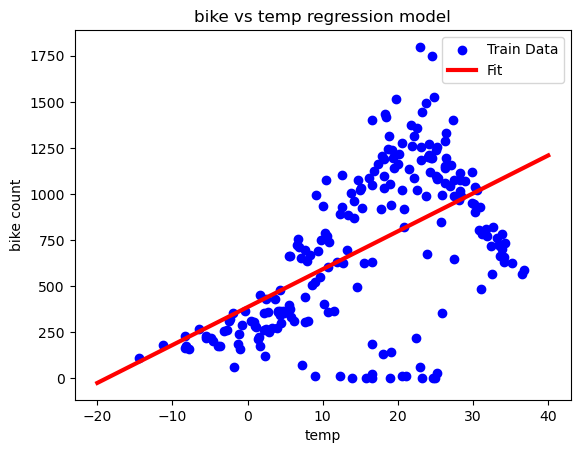

In [57]:
plt.scatter(x = X_train_temp12, y = y_train_temp12, label = "Train Data", color = "blue")
X_to_be_predicted_temp_regression_model12 = tf.linspace(-20, 40, 100) # predicting from -20 degrees to 40 degrees
plt.plot(X_to_be_predicted_temp_regression_model12, temp_regression_model12.predict(np.array(X_to_be_predicted_temp_regression_model12).reshape(-1, 1)), label = "Fit", color = "red", linewidth = 3) # np.array() and reshape() is for changing the input shape of x to the required shape, i.e. (len(feature_vector), 1)
plt.title("bike vs temp regression model")
plt.ylabel("bike count")
plt.xlabel("temp")
plt.legend()
plt.show()

### Multiple linear regression

$y = \beta_0 + \beta_1{x_1} + \beta_2{x_2} + ... + \beta_p{x_p}$ where $\beta_0$ is the $y$ intercept and $\beta_1, \beta_2, ...$ are the coefficients for the features, $\epsilon$ is a error variable(random variable)

In [101]:
_, X_train12, y_train12 = get_Xy(dataframe = train12, y_label = "bike_count")
_, X_validation12, y_validation12 = get_Xy(dataframe = validation12, y_label = "bike_count")
_, X_test12, y_test12 = get_Xy(dataframe = test12, y_label = "bike_count")

In [102]:
print(X_train12)

[[-0.3 45.   2.2 ...  3.   1.   1. ]
 [28.2 34.   2.6 ...  2.   1.   1. ]
 [18.2 15.   1.6 ...  1.   1.   1. ]
 ...
 [31.7 45.   2.5 ...  2.   1.   1. ]
 [-1.3 17.   1.5 ...  3.   0.   1. ]
 [33.4 47.   1.3 ...  2.   1.   1. ]]


In [103]:
regression_model12 = LinearRegression()
regression_model12.fit(X = X_train12, y = y_train12)

LinearRegression()

In [104]:
regression_model12.score(X_test12, y_test12)

0.7498119527175404

### Neural net regression

In [105]:
def plot_loss(history: tf.keras.callbacks.History, ax: plt.Axes = None):
    show_plot = False
    if ax == None:
        _, ax = plt.subplots()
        show_plot = True
    ax.plot(history.history['loss'], label = 'loss')
    ax.plot(history.history['val_loss'], label = 'val_loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Binary crossentropy')
    ax.legend()
    ax.grid(True)
    if show_plot:
        plt.show()

def plot_accuracy(history: tf.keras.callbacks.History, ax: plt.Axes):
    show_plot = False
    if ax == None:
        _, ax = plt.subplots()
        show_plot = True
    ax.plot(history.history['accuracy'], label = 'accuracy')
    ax.plot(history.history['val_accuracy'], label = 'val_accuracy')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.grid(True)
    if show_plot:
        plt.show()

def plot_loss_accuracy(history: tf.keras.callbacks.History, title: str):
    fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
    plot_loss(history = history, ax = ax1)
    plot_accuracy(history = history, ax = ax2)
    plt.title(title)
    plt.show()

In [106]:
# Normalizer for dataset with only temp feature

temp_normalizer12 = tf.keras.layers.Normalization(input_shape = (1, ), axis = None) # input_shape of (1, ) implies there is one feature for the len(X_train_temp12) data points
# Note: input_shape only applies to the ffirst/ input layer in the sequential layers
temp_normalizer12.adapt(X_train_temp12.reshape(-1,))  # The reshape function takes a tuple of shape dimensions(-1 to mean a single dimension and let np calculate the length of that dimension)

#### Single feature NN regression with single node

In [107]:
temp_nn_single_node_model12 = tf.keras.Sequential([
    temp_normalizer12,
    tf.keras.layers.Dense(1)
])
temp_nn_single_node_model12.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1), loss = "mean_squared_error")

In [108]:
temp_nn_single_node_model12_history = temp_nn_single_node_model12.fit(x = X_train_temp12.reshape(-1,),
                                                                      y = y_train_temp12,
                                                                      batch_size = 32,
                                                                      verbose = 1,
                                                                      epochs = 1000,
                                                                      validation_data = (X_validation_temp12, y_validation_temp12))

Epoch 1/1000


7/7 [==============================] - 0s 9ms/step - loss: 682334.1875 - val_loss: 710937.9375
Epoch 2/1000
7/7 [==============================] - 0s 3ms/step - loss: 681066.7500 - val_loss: 709572.7500
Epoch 3/1000
7/7 [==============================] - 0s 3ms/step - loss: 679770.0625 - val_loss: 708206.4375
Epoch 4/1000
7/7 [==============================] - 0s 3ms/step - loss: 678505.5000 - val_loss: 706839.9375
Epoch 5/1000
7/7 [==============================] - 0s 3ms/step - loss: 677218.3125 - val_loss: 705492.2500
Epoch 6/1000
7/7 [==============================] - 0s 3ms/step - loss: 675943.8750 - val_loss: 704147.3750
Epoch 7/1000
7/7 [==============================] - 0s 3ms/step - loss: 674662.8750 - val_loss: 702810.6875
Epoch 8/1000
7/7 [==============================] - 0s 3ms/step - loss: 673391.9375 - val_loss: 701476.2500
Epoch 9/1000
7/7 [==============================] - 0s 3ms/step - loss: 672100.0000 - val_loss: 700159.8125
Epoch 10/1000
7/7 [======================

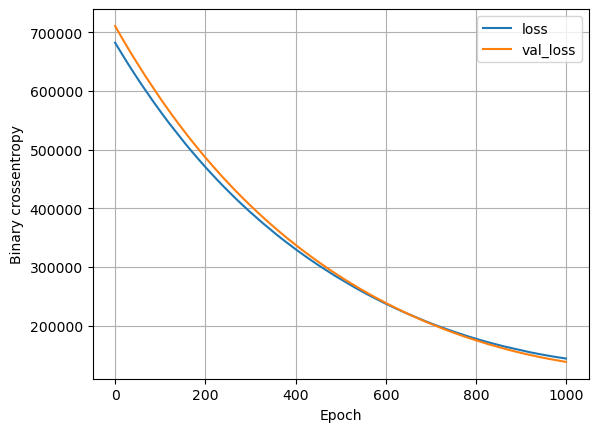

In [109]:
plot_loss(temp_nn_single_node_model12_history)

4/4 [==============================] - 0s 736us/step


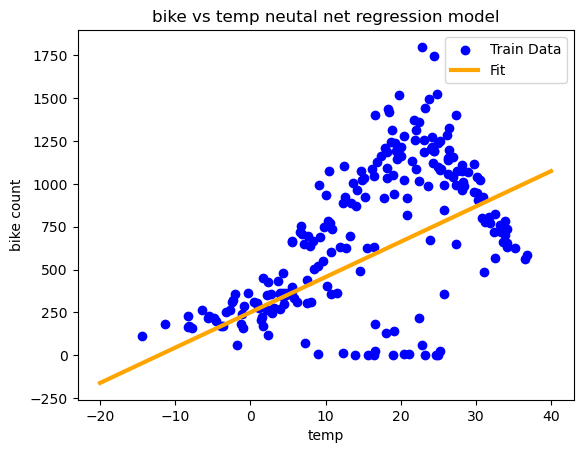

In [110]:
plt.scatter(x = X_train_temp12, y = y_train_temp12, label = "Train Data", color = "blue")
X_to_be_predicted_temp_nn_regression_model12 = tf.linspace(-20, 40, 100) # predicting from -20 degrees to 40 degrees
plt.plot(X_to_be_predicted_temp_nn_regression_model12, temp_nn_single_node_model12.predict(np.array(X_to_be_predicted_temp_nn_regression_model12).reshape(-1, 1)), label = "Fit", color = "orange", linewidth = 3) # np.array() and reshape() is for changing the input shape of x to the required shape, i.e. (len(feature_vector), 1)
plt.title("bike vs temp neutal net regression model")
plt.ylabel("bike count")
plt.xlabel("temp")
plt.legend()
plt.show()

#### All feature NN regression with single node

In [117]:
all_normalizer12 = tf.keras.layers.Normalization(input_shape = (X_train12.shape[1], ), axis = None)
all_normalizer12.adapt(X_train12)

In [118]:
all_nn_single_node_model12 = tf.keras.Sequential(layers = [
    all_normalizer12,
    tf.keras.layers.Dense(1)
])

all_nn_single_node_model12.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1), loss = "mean_squared_error")

In [119]:
print(X_train12.shape)
all_nn_single_node_model12_history = all_nn_single_node_model12.fit(x = X_train12,
                                                                    y = y_train12,
                                                                    batch_size = 32,
                                                                    verbose = 1,
                                                                    epochs = 1000,
                                                                    validation_data = (X_validation12, y_validation12))

(219, 11)
Epoch 1/1000


7/7 [==============================] - 0s 9ms/step - loss: 678395.1250 - val_loss: 703821.2500
Epoch 2/1000
7/7 [==============================] - 0s 3ms/step - loss: 671549.8125 - val_loss: 697004.4375
Epoch 3/1000
7/7 [==============================] - 0s 3ms/step - loss: 664699.0625 - val_loss: 690261.5000
Epoch 4/1000
7/7 [==============================] - 0s 3ms/step - loss: 657984.5000 - val_loss: 683554.4375
Epoch 5/1000
7/7 [==============================] - 0s 3ms/step - loss: 651238.7500 - val_loss: 676939.8125
Epoch 6/1000
7/7 [==============================] - 0s 3ms/step - loss: 644643.0000 - val_loss: 670366.6250
Epoch 7/1000
7/7 [==============================] - 0s 3ms/step - loss: 638077.0000 - val_loss: 663869.3125
Epoch 8/1000
7/7 [==============================] - 0s 3ms/step - loss: 631571.9375 - val_loss: 657440.6875
Epoch 9/1000
7/7 [==============================] - 0s 3ms/step - loss: 625145.3750 - val_loss: 651084.2500
Epoch 10/1000
7/7 [======================

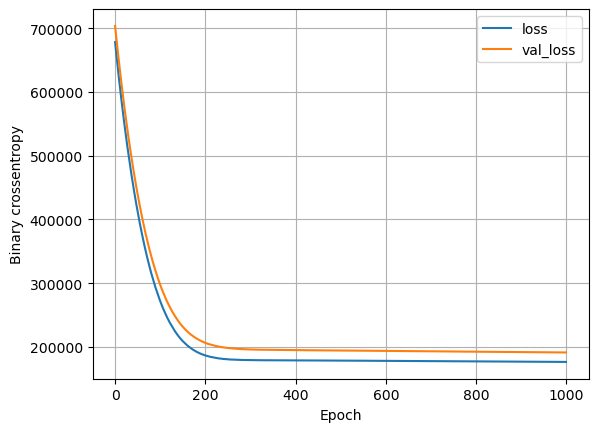

In [120]:
plot_loss(all_nn_single_node_model12_history)

7/7 [==============================] - 0s 834us/step


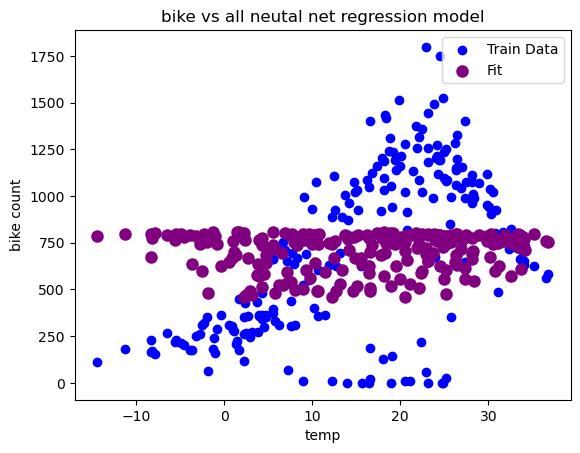

In [139]:
plt.scatter(x = X_train_temp12, y = y_train_temp12, label = "Train Data", color = "blue")
plt.scatter(X_train12[:, 0], all_nn_single_node_model12.predict(np.array(X_train12)), label = "Fit", color = "purple", linewidth = 3) # the `0` in [:, 0] denotes the first feature, i.e. `temp`
plt.title("bike vs all neutal net regression model")
plt.ylabel("bike count")
plt.xlabel("temp")
plt.legend()
plt.show()

#### Single feature NN regression with multiple nodes
This is not a "linear" regression, since we have a number of nodes in the hidden layers

In [144]:
import keras
temp_nn_model12 = tf.keras.Sequential([
    temp_normalizer12,
    tf.keras.layers.Dense(32, activation = "relu"),
    tf.keras.layers.Dense(32, activation = "relu"),
    tf.keras.layers.Dense(1)
])
temp_nn_model12.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1), loss = "mean_squared_error")

In [145]:
temp_nn_model12_history = temp_nn_model12.fit(x = X_train_temp12,
                                              y = y_train_temp12,
                                              batch_size = 32,
                                              verbose = 1,
                                              epochs = 1000,
                                              validation_data = (X_validation_temp12, y_validation_temp12))

Epoch 1/1000


7/7 [==============================] - 0s 11ms/step - loss: 647064.3750 - val_loss: 527572.6875
Epoch 2/1000
7/7 [==============================] - 0s 3ms/step - loss: 317686.9688 - val_loss: 204854.6250
Epoch 3/1000
7/7 [==============================] - 0s 3ms/step - loss: 205690.4688 - val_loss: 132266.3281
Epoch 4/1000
7/7 [==============================] - 0s 3ms/step - loss: 140510.5156 - val_loss: 123720.4688
Epoch 5/1000
7/7 [==============================] - 0s 3ms/step - loss: 134268.6250 - val_loss: 119015.7266
Epoch 6/1000
7/7 [==============================] - 0s 3ms/step - loss: 129850.3594 - val_loss: 124457.5859
Epoch 7/1000
7/7 [==============================] - 0s 3ms/step - loss: 133658.9531 - val_loss: 113269.8359
Epoch 8/1000
7/7 [==============================] - 0s 3ms/step - loss: 124586.2031 - val_loss: 116994.7422
Epoch 9/1000
7/7 [==============================] - 0s 3ms/step - loss: 126675.9141 - val_loss: 110649.8359
Epoch 10/1000
7/7 [=====================

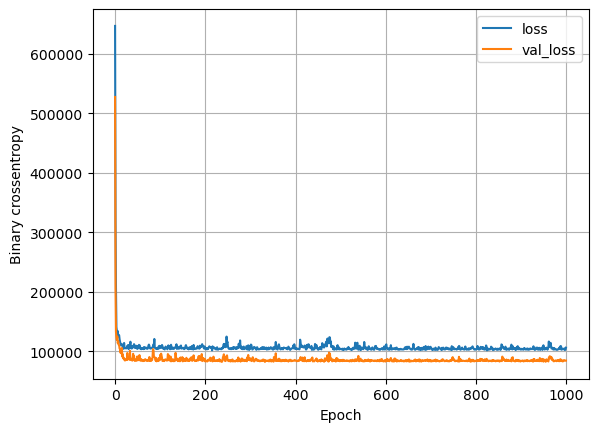

In [146]:
plot_loss(temp_nn_model12_history)

4/4 [==============================] - 0s 758us/step


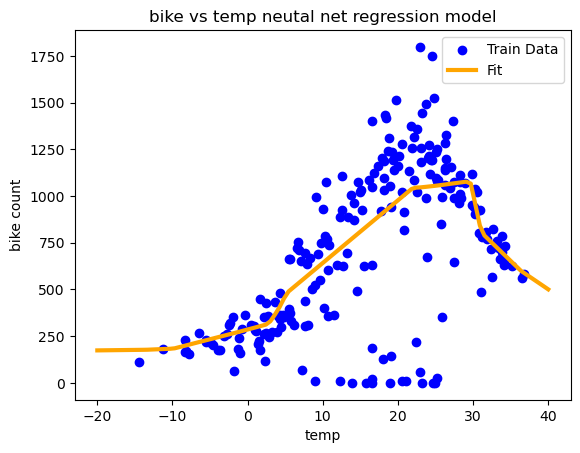

In [147]:
plt.scatter(x = X_train_temp12, y = y_train_temp12, label = "Train Data", color = "blue")
plt.plot(X_to_be_predicted_temp_nn_regression_model12, temp_nn_model12.predict(np.array(X_to_be_predicted_temp_nn_regression_model12).reshape(-1, 1)), label = "Fit", color = "orange", linewidth = 3) # np.array() and reshape() is for changing the input shape of x to the required shape, i.e. (len(feature_vector), 1)
plt.title("bike vs temp neutal net regression model")
plt.ylabel("bike count")
plt.xlabel("temp")
plt.legend()
plt.show()

4/4 [==============================] - 0s 1ms/step


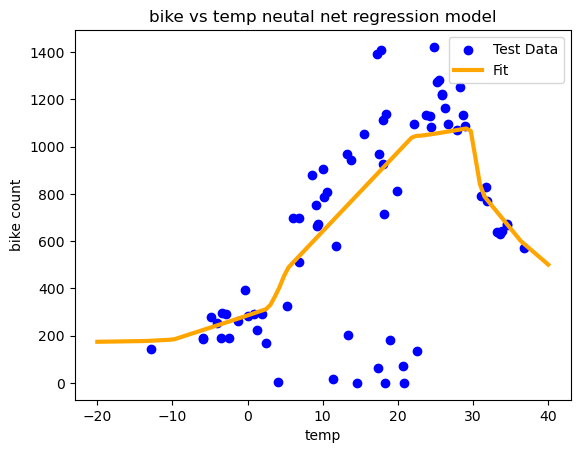

In [148]:
plt.scatter(x = X_test_temp12, y = y_test_temp12, label = "Test Data", color = "blue")
plt.plot(X_to_be_predicted_temp_nn_regression_model12, temp_nn_model12.predict(np.array(X_to_be_predicted_temp_nn_regression_model12).reshape(-1, 1)), label = "Fit", color = "orange", linewidth = 3) # np.array() and reshape() is for changing the input shape of x to the required shape, i.e. (len(feature_vector), 1)
plt.title("bike vs temp neutal net regression model")
plt.ylabel("bike count")
plt.xlabel("temp")
plt.legend()
plt.show()

#### Multiple feature NN regression with multiple nodes

In [154]:
all_nn_model12 = tf.keras.Sequential([
    all_normalizer12,
    tf.keras.layers.Dense(32, activation = "relu"),
    tf.keras.layers.Dense(32, activation = "relu"),
    tf.keras.layers.Dense(1)
])
all_nn_model12.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1), loss = "mean_squared_error")

In [155]:
all_nn_model12_history = all_nn_model12.fit(x = X_train12,
                                            y = y_train12,
                                            batch_size = 32,
                                            verbose = 1,
                                            epochs = 1000,
                                            validation_data = (X_validation12, y_validation12))

Epoch 1/1000


7/7 [==============================] - 0s 10ms/step - loss: 632755.9375 - val_loss: 483491.7188
Epoch 2/1000
7/7 [==============================] - 0s 3ms/step - loss: 303386.5312 - val_loss: 257967.4219
Epoch 3/1000
7/7 [==============================] - 0s 3ms/step - loss: 200904.2812 - val_loss: 235373.2656
Epoch 4/1000
7/7 [==============================] - 0s 3ms/step - loss: 202871.8594 - val_loss: 194806.7969
Epoch 5/1000
7/7 [==============================] - 0s 3ms/step - loss: 198711.1094 - val_loss: 195246.9375
Epoch 6/1000
7/7 [==============================] - 0s 3ms/step - loss: 184434.7812 - val_loss: 209096.5156
Epoch 7/1000
7/7 [==============================] - 0s 3ms/step - loss: 181689.3906 - val_loss: 194956.3750
Epoch 8/1000
7/7 [==============================] - 0s 3ms/step - loss: 183724.7188 - val_loss: 193526.2656
Epoch 9/1000
7/7 [==============================] - 0s 3ms/step - loss: 180698.3438 - val_loss: 198635.3594
Epoch 10/1000
7/7 [=====================

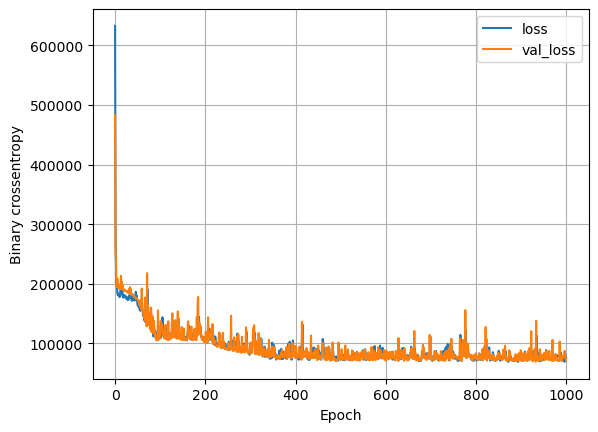

In [156]:
plot_loss(all_nn_model12_history)

7/7 [==============================] - 0s 591us/step


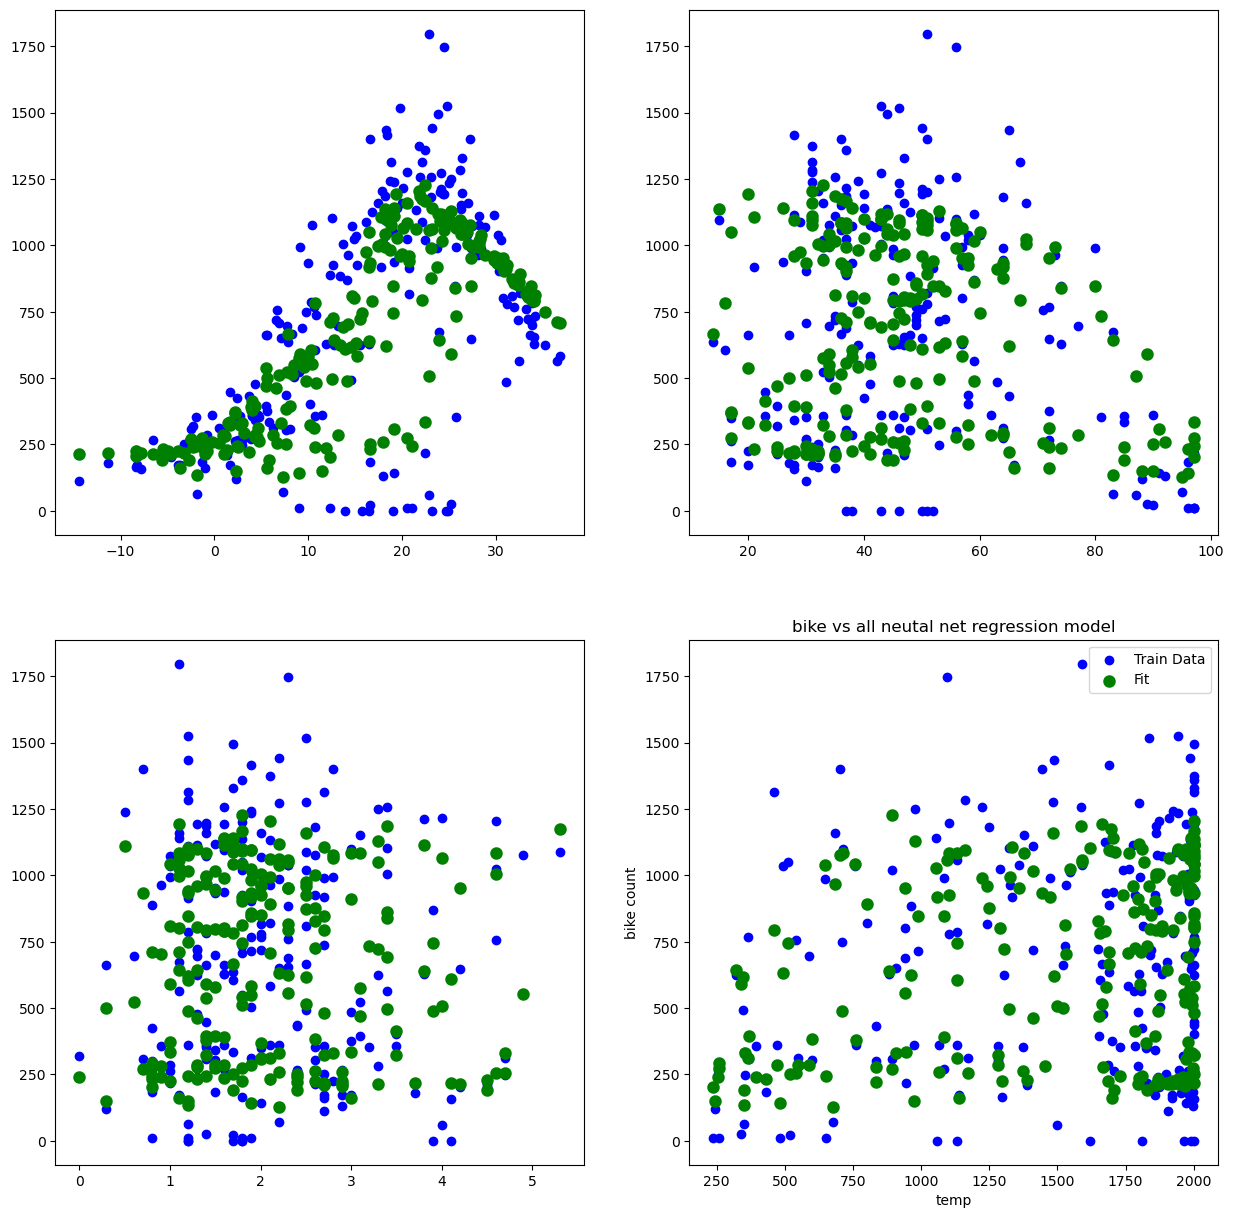

In [163]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 15))
def scatter(ax: plt.Axes, featureIndex: int):
    ax.scatter(x = X_train12[:, featureIndex], y = y_train12, label = "Train Data", color = "blue")
    ax.scatter(X_train12[:, featureIndex], all_nn_model12.predict(np.array(X_train12)), label = "Fit", color = "green", linewidth = 3)
scatter(ax1, 0)
scatter(ax2, 1)
scatter(ax3, 2)
scatter(ax4, 3)
plt.title("bike vs all neutal net regression model")
plt.ylabel("bike count")
plt.xlabel("temp")
plt.legend()
plt.show()

3/3 [==============================] - 0s 1ms/step


3/3 [==============================] - 0s 775us/step


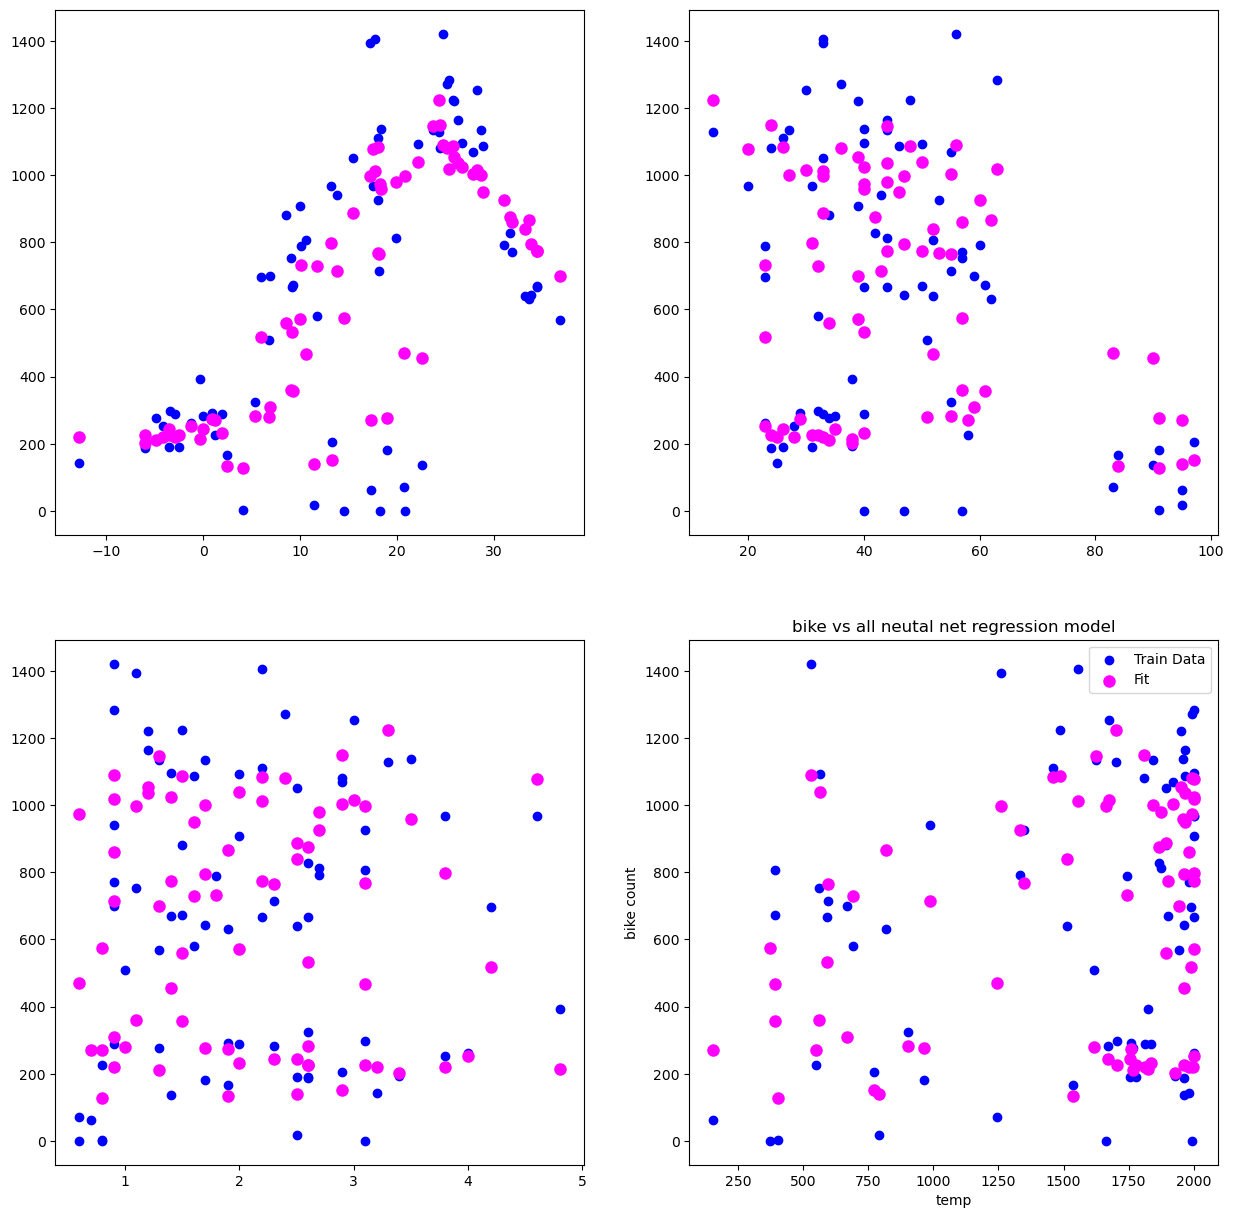

In [165]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 15))
def scatter(ax: plt.Axes, featureIndex: int):
    ax.scatter(x = X_test12[:, featureIndex], y = y_test12, label = "Train Data", color = "blue")
    ax.scatter(X_test12[:, featureIndex], all_nn_model12.predict(np.array(X_test12)), label = "Fit", color = "magenta", linewidth = 3)
scatter(ax1, 0)
scatter(ax2, 1)
scatter(ax3, 2)
scatter(ax4, 3)
plt.title("bike vs all neutal net regression model")
plt.ylabel("bike count")
plt.xlabel("temp")
plt.legend()
plt.show()

### Measure performance of linear regression vs neural net

In [168]:
def MSE(y_pred, y_real):
    return np.square(y_pred - y_real).mean()

In [171]:
y_pred12_lr = regression_model12.predict(X = X_test12)
y_pred12_nn = all_nn_model12.predict(X_test12)

3/3 [==============================] - 0s 1ms/step


In [172]:
print(MSE(y_pred = y_pred12_lr, y_real = y_test12))
print(MSE(y_pred = y_pred12_nn, y_real = y_test12))

44383.70578544269
63854.50084854698


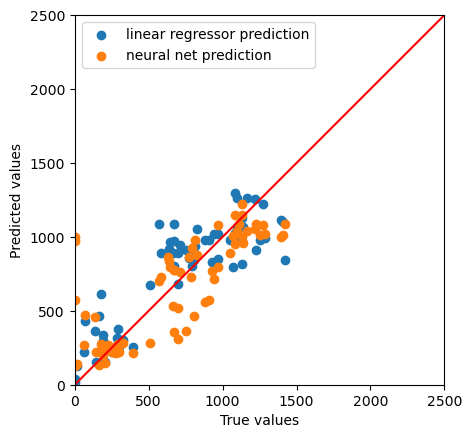

In [177]:
ax = plt.axes(aspect = "equal")
plt.scatter(y_test12, y_pred12_lr, label = "linear regressor prediction")
plt.scatter(y_test12, y_pred12_nn, label = "neural net prediction")
plt.xlabel("True values")
plt.ylabel("Predicted values")
lims = [0, 2500]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ = plt.plot(lims, lims, color = "red")